# This program compares projection targets for two injection areas

## Setting up initial dependencies:

In [637]:
#set drive and import
drive_path = '/Volumes/Brain2016'
import os
import numpy as np
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
from prettytable import PrettyTable
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## This is where all parameters (regions, thresholds) are indicated:

In [638]:
#global parameters 
rnames = ['LO','MO'] #names for two regions for the dictionary this will create
settings = ['one','two','three'] #different settings to loop through that are defined later
#visualization params
proj_thresh = 5 #threshold for plotting projection volume by region
site_number = 3 #number of top projection sites to look at
dfnames = ['df_proj_large_dense','df_greatest_projection_volumes']

In [639]:
#variable parameters
def get_params(setting): #try a range of parameters to define regions 
    regions = {} 
    if setting == 'three':
        include,exclude = [['ORBl','AIv','AId'],['ORBm','ORBvl']], [[],['ORBl']] #regions to exclude if this is the second most voluminous site after the target:      
        #pick which experiments to throw out
        #off the bat, throw out anything that meets these criteria:
        bad_vol = .55 #cut off for not enough injected into my ROI
        corr_max = 0.1 #maximum correlation of injection area between the two different regions you're looking at
        diff_thresh=0.02 #plotting threshold for projection differences
        #names for pickle files so new ones are created at each iteration:
        fnames,fnames2,fnames3 = ['a1','a2','a3','a4'],['a5','a6','a7','a8'],['a9','a10','a11','a12']
        dense = large = 0.25
    elif setting == 'two':
        include,exclude = [['ORBl','AIv','AId'],['ORBm','ORBvl']], [[],['ORBl']]
        bad_vol,corr_max,diff_thresh = .6,0,0.05
        fnames,fnames2,fnames3 =['b1','b2','b3','b4'],['b5','b6','b7','b8'],['b9','b10','b11','b12']
        dense = large = 0.2
    elif setting == 'one':
        include, exclude = [['ORBl'],['ORBm']],[[],['ORBl']]
        bad_vol,corr_max,diff_thresh = .51, 0, 0.1
        fnames,fnames2,fnames3 =['d1','d2','d3','d4'],['d5','d6','d7','d8'],['d9','d10','d11','d12'] 
        dense = large = 0.15
    elif setting == 'four':
        include, exclude = [['ORBl','AIv','AId'],['ORBm','ORBvl']], [[],[]]
        bad_vol,corr_max,diff_thresh = .51, 0.1, 0.1
        fnames,fnames2,fnames3 =['d1','d2','d3','d4'],['d5','d6','d7','d8'],['d9','d10','d11','d12'] 
        dense = large = 0.25
    elif setting == 'five':
        include, exclude = [['ORBl'],['ORBm']],[[],['ORBl']]
        bad_vol,corr_max,diff_thresh = .55, 0, 0.1
        fnames,fnames2,fnames3 =['d1','d2','d3','d4'],['d5','d6','d7','d8'],['d9','d10','d11','d12'] 
        dense = large = 0.2
    for z,i in enumerate(rnames): #make a dictionary combining everything by region
        i = {}
        i['include'] = include[z]
        i['exclude'] = exclude[z]
        regions[rnames[z]] = i
    return regions,bad_vol,corr_max,diff_thresh,fnames,fnames2,fnames3,dense,large

## Functions to get data from the Allen SDK:

In [640]:
def get_data():
    #get the experiment data
    # When downloading 3D connectivity data volumes, what resolution do you want (in microns)?  
    # Options are: 10, 25, 50, 100
    resolution_um=25 #do not change
    # The manifest file is a simple JSON file that keeps track of all of
    # the data that has already been downloaded onto the hard drives.
    # If you supply a relative path, it is assumed to be relative to your
    # current working directory.
    manifest_file = os.path.join(drive_path, "MouseConnectivity","manifest.json")
    mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)
    # open up a pandas dataframe of all of the experiments
    all_experiments = mcc.get_experiments(dataframe=True)
    return(mcc,all_experiments)

In [641]:
def get_ont(mcc):
    #set up ontology & summary naming 
    ontology,names = mcc.get_ontology(),mcc.get_structures()
    grey = ontology['grey']
    return(ontology,names,grey)

In [642]:
#make dictionary to read structure abbreviations & names
def make_dict(names):
    name_d = {}
    keys = names['acronym'].index
    ac,name = dict(zip(keys, names['acronym'].values)),dict(zip(keys, names['name'].values ))
    name_d['ac'] = ac 
    name_d['name'] = name
    return name_d 

## Functions for defining the experiments by injection site:

### Functions working with structure level anatomy:

In [643]:
#first get all the ORBl & ORBm expts
def get_your_experiments(regions,ontology,mcc):
    for k,v in regions.iteritems():
        temp = mcc.get_experiments(injection_structure_ids= ontology[v['include']]['id'],dataframe = True)
        temp2 = mcc.get_experiments(injection_structure_ids= ontology[v['include']]['id'],dataframe = True,cre=False)
        regions[k]['experiments'],regions[k]['wt'] = temp.id.values,temp2.id.values
        print(k + ": %d total experiments under setting" % len(temp.id.values))
    return regions

In [644]:
#see how much of your injection was in the site
def make_table_by_proportion_inj(regions,mcc,ontology,name_d,bad_vol):
    for k,v in regions.iteritems():
        columns_to_display = ['experiment_id','normalized_projection_volume']
        inj = mcc.get_structure_unionizes(v['experiments'], is_injection=True, hemisphere_ids=[3])
        grouped = inj[inj['structure_id'].isin(ontology[v['include']]['id'])]
        grouped = grouped[columns_to_display].groupby(['experiment_id']).sum()
        #grouped = grouped['normalized_projection_volume'].sort_values()
        #grouped['index'] = grouped.index
        #plot_proj_bar(grouped,start_fig=0,xs='index',ys='normalized_projection_volume',ylab="# normalized projection volume",title=("Proportion injections in " + k))
        ok = get_inj_stuff(v,ontology)
        columns_to_display = ['structure_id','experiment_id','normalized_projection_volume']
        grouped2 = inj[columns_to_display].sort_values(by = ['experiment_id','normalized_projection_volume'],ascending=False)
        grouped2['struct_name']= grouped2['structure_id'].copy()
        grouped2['struct_name'].replace(name_d['ac'], inplace=True)
        grouped2 = grouped2[~grouped2['struct_name'].isin(ok)]
        grouped2 = grouped2.groupby('experiment_id').first()
        grouped2['good_vol'] = grouped.normalized_projection_volume.values
        grouped2=grouped2.rename(columns = {'normalized_projection_volume':'bad_vol'})
        grouped2['ratio'] = grouped2['bad_vol']/grouped2['good_vol']
        grouped2 =grouped2[grouped['normalized_projection_volume']>bad_vol]
        grouped2 = grouped2[~grouped2['struct_name'].isin(v['exclude'])]
        columns_to_display = ['good_vol','bad_vol','ratio','struct_name']
        grouped2 = grouped2[columns_to_display]
        #grouped2 = grouped2.sort_values(by = 'good_vol')
        regions[k]['df_injection_volumes'] = grouped2
    return regions

In [645]:
def get_inj_stuff(v,ontology):
    good = np.array
    for j in (v['include']):
        a = ontology.df[ontology.df.acronym.str.contains(j)] 
        good = np.insert(good,0, a['acronym'].values)
    if any('AI' in s for s in v['include']): good = np.insert(good,0,'AI')
    ok = np.insert(good,0,['root','CTX','grey','CTXpl','Isocortex','CH','ORB'])
    return ok

### Functions working with pixel level anatomy by using masks. Injection & projection

In [646]:
def define_mask_area(ttype,v,dfname):
    if ttype ==0: #look at each projection target specifically
        area = name = v[dfname]['id']
    elif ttype == 1: #injection regions cumulatve
        area = v['include']
        name = area[0]
    elif ttype == 2: #proj regions cumulative
        area,name = v[dfname]['id'],'main_proj_targets'
    return area,name

In [647]:
#make masks for LO & MO
def get_brain_masks(regions,mcc,ontology,ttype,dfname):
    brain_mask = {}
    good_vo = np.zeros([528, 320, 456])
    for k,v in regions.iteritems():
        area,name = define_mask_area(ttype,v,dfname)
        if (ttype ==1) or (ttype ==2): #sum over areas
            brain_mask = {}
            for j in ontology[area]['id']:
                good_vol, _ = mcc.get_structure_mask(j)
                good_vo = good_vo + good_vol
            brain_mask[name] = np.where(good_vo)
        elif (ttype==0): #make a mask for each area
            for j in ontology[area]['id']:
                good_vol, _ = mcc.get_structure_mask(j)
                brain_mask[j] = np.where(good_vol)
        if (ttype ==0):
            print('') #there's only one mask for the whole brain
        elif (ttype ==2):
            v['brain_mask']= brain_mask
        elif ttype == 1:
            v['brain_mask']= brain_mask
            good_vo = np.zeros([528, 320, 456]) #for the other version we want to add all possible regions
    v['brain_mask']= brain_mask
    return regions

In [648]:
#see where injections were in LO/MO
def get_masks(regions,mcc,ttype,dfname): 
    mask_area = {}
    for k,v in regions.iteritems():#loop through masks
        area,name = define_mask_area(ttype,v,dfname)
        mask = k     
        d = {}
        for kk,vv in regions.iteritems(): #loop through experiments by region
            ex = np.array(vv['df_injection_volumes'].index)
            df = pd.DataFrame(columns = ex)
            if (ttype ==1) or (ttype ==2): #sum over areas 
                for i,experiment_id in enumerate(ex):
                    pd2, _ = mcc.get_injection_density(experiment_id)
                    df[experiment_id] = pd2[v['brain_mask'][name]]
                d[kk] = df #mask name,area name
            elif (ttype==0): #have a mask for each area
                x = {}
                for j in v['brain_mask']:
                    df = pd.DataFrame(columns = ex)
                    for i,experiment_id in enumerate(ex):
                        pd2, _ = mcc.get_injection_density(experiment_id)
                        df[experiment_id] = pd2[v['brain_mask'][j]]
                        #print(experiment_id)
                        #print(df.head())
                    x[j] = df   
                d[kk] = x #mask name,area name
            mask_area[mask] = d 
        if ttype ==0: 
            break #there's only one mask for the whole brain
        elif ttype == 2:
            #mask_area[mask] = df 
            break      
    return mask_area

In [650]:
#correlations between mask and experiment voxels
def get_corr(mask_area,ttype):
    Dict4 = {}
    for mask,area in mask_area.iteritems(): #for each mask except 0 loops below
        ks = area.keys()
        if (ttype ==0) or (ttype == 2): #want all 3 possible correlations (within and between regions)
            it = [[ks[0], ks[0]], [ks[0], ks[1]], [ks[1], ks[1]]]
        elif ttype == 1: #regions
            it = [[ks[0], ks[1]]]
        for i in it:
            if ttype == 0:
                name = (i[0]+'v' + i[1] +"mask")  
                # mask_area is: mask_area['LO']['LO' OR 'MO'][j][experiment_id]
                v0s = area[i[0]] #for every experiment,ex there are results by mask for each indicated area
                v1s = area[i[1]]
                by_mask = {}
                for j in v0s: #for each mask
#                   cols = v0[j].keys() #expt names
#                   rows = v1[j].keys() #expt 2 names
                    #print(j)
                    #print(v0s)
                    df_arr = corr_func(v0s[j],v1s[j],Dict4)
                    by_mask[j] = df_arr
                #print(name)
                Dict4[name] = by_mask 
            else:
                v0 = area[i[0]]
                v1 = area[i[1]]
                #print(i[0])
                #print(i[1])
                #print(mask)
                name = (i[0]+'v' + i[1] +"mask" + mask)
                df_arr = corr_func(v0,v1,Dict4) 
                Dict4[name] = df_arr 
    return Dict4

In [651]:
def corr_func(v0,v1,Dict4):
    cols = v0.columns
    rows = v1.columns
    n = [len(cols),len(rows)]
    a = np.empty(n)
    df_arr = pd.DataFrame(columns=cols)
    for ii in cols:
        c = np.empty(n[1])
        j = -1
        for jj in rows:
            j = j + 1
            b = np.corrcoef(v0[ii].values, v1[jj].values)
            c[j]=(b[0,1])
        df_arr[ii] = pd.Series(c)
    df_arr.set_index(rows,inplace=True)
    return df_arr

## Injection correlation functions:

In [652]:
def filter_expts(Dict4,regions,corr_max):
    #filter data loop calling functs
    expts,max_corr = find_corr_inj(Dict4,corr_max)
    #loop through and remove most correlated injections until a criteria is met
    while max_corr>corr_max:
        rem = id_expts(regions,expts)
        Dict4,dvols = rem_expts(rem,Dict4,regions)
        expts,max_corr = find_corr_inj(Dict4,corr_max)
    return Dict4,regions

In [653]:
#find the index that is most highly correlated
def find_corr_inj(Dict4,corr_max):
    cols = ('max','col','row')
    df2 = pd.DataFrame(columns = cols)
    i = 0
    for k,df in Dict4.iteritems(): #columns are LO, rows MO
        mm = df.max().max()
        if (np.isnan(mm)) or mm<corr_max:
            max_corr = -1 #exit loop
            expts = []
            break
        colmax = df.max()[df.max() == df.max(axis=1).max()].index
        rmax = (df[colmax].idxmax().values).astype(dtype='int64')
        st = [mm, colmax[0], rmax[0]]
        df2.loc[i]=st
        i = i + 1
    if np.isnan(mm)==False and mm>corr_max:
        max_corr = df2['max'].max()
        ins = df2['max'].idxmax()
        expts = df2.loc[ins, 'col':'row']
        expts = expts.tolist()
    return expts,max_corr

In [654]:
#for the two most correlated injection sites between regions,
#check the fraction correct inj. volume between the two; delete the one that has the least
def id_expts(regions,expts):
    val=[]
    wts = []
    for k,v in regions.iteritems():
        wts.append(v['wt'])
    wts = wts[0].tolist()+ wts[1].tolist()
    for k,v in regions.iteritems(): #where volume dataframes are for expt
        c = v['df_injection_volumes']['good_vol']
        a = c[c.index.isin(expts)]
        val.append((a.values))
    notwt = (set(expts)-(set(expts) & set(wts))).pop()
    if np.shape(notwt) ==1:
        rem == notwt
    else:
        rem = expts[np.argmin(val)]
    return rem

In [655]:
#update regions,Dict4 to remove expts that overlap too much
def rem_expts(rem,Dict4,regions):
    for k,df in Dict4.iteritems():
        truth = np.array([df.columns==rem])
        if np.any(truth): #LO
            df.drop([rem],inplace=True,axis=1)
        Dict4[k] = (df[~(df.index == rem)]) #MO
    for k,v in regions.iteritems():
        v['experiments'][v['experiments']!=rem]
    return Dict4,regions

## projection site processing

In [656]:
#plot how much of the projection was in each region of the brain for all experiments 
def make_table_by_proj_region(regions,proj_thresh,mcc,grey,name_d,ontology,dense,large):
    for k,v in regions.iteritems():
        #v['experiments'] is all experiments
        remove = ['root','CTX','grey','CTXpl','Isocortex','CH']
        columns_to_display = ['struct_name','normalized_projection_volume']
        inj = mcc.get_structure_unionizes(v['df_injection_volumes'].index, structure_ids = grey['id'],is_injection=False,hemisphere_ids=[3])
        inj['struct_name']= inj['structure_id'].copy()
        inj['struct_name'].replace(name_d['ac'], inplace=True)
        inj = inj[~inj['struct_name'].isin(remove)]
        df2 = make_summary(inj,ontology,k,name_d,dense,large)
        df2 = df2[~df2['struct_name'].isin(remove)]
        df2 = df2[:site_number] #filter to my number of sites
        v['df_proj_large_dense'] = df2
        table = format_for_print(df2)
        print(table)
        grouped = inj.groupby(['structure_id'],as_index=True).mean()
        grouped['struct_name']= grouped.index.astype(int) #for some reason i need to do this again because it
        grouped['struct_name'].replace(name_d['name'], inplace=True)
        d = grouped.sort_values(by='normalized_projection_volume',ascending=False)
        d = d[:site_number] #filter to my number of sites
        d = d[columns_to_display]
        #plot_proj_bar(d,start_fig=0,xs='struct_name',ys='normalized_projection_volume',ylab="# normalized projection volume",title=("Projection sites targeted by " + k))
        d.columns = ['struct_name','vol']
        d['id'] = d.index
        v['df_greatest_projection_volumes'] = d
        table = format_for_print(d)
        print("The structures receiving the most projections on average were:")
        print(table)
        #print(len(d.index))
    return regions


In [657]:
def make_summary(structure_unionizes,ontology,k,name_d,dense,large):
    #print(structure_unionizes.head())
    dense_unionizes = structure_unionizes[ structure_unionizes.projection_density > dense ]
    large_unionizes = dense_unionizes[ dense_unionizes.volume > large ]
    large_structures = ontology[large_unionizes.structure_id]
    print("%d large, dense, cortical, non-injection unionizes, %d structures in %s" % ( len(large_unionizes), len(large_structures),k ))
    print("The top %d are: "%site_number)
    df2 = large_unionizes[['normalized_projection_volume','struct_name','structure_id']]
    df2 = df2.groupby(['structure_id'],as_index=True).agg(['sum', 'count'])
    df2.columns = df2.columns.get_level_values(0)
    df2.columns = ['vol','count','id','del']
    df2.drop(['del'],inplace=True,axis=1)
    df2 = df2.sort_values(by='vol',ascending=False)
    df2['id'] = df2.index
    df2['struct_name']= df2['id'].copy()
    df2['struct_name'].replace(name_d['ac'], inplace=True)
    return df2

In [658]:
def compare_proj(regions,ndf,diff_thresh):
    d =  ndf[['struct_name','diffs']]#[np.abs(ndf['diffs'])>diff_thresh] 
    plot_proj_bar(d,start_fig=0,xs='struct_name',ys='diffs',ylab="diff normalized projection volume",title="targets diff LO - MO")

In [659]:
def simple_proj_corr(regions):
    for k,v in regions.iteritems():
        #normalize to total inj in this area
        norm = (v['df_greatest_projection_volumes']['vol'].sum())
        v['df_greatest_projection_volumes'].vol = (v['df_greatest_projection_volumes'].vol/norm)
    ks = regions.keys()
    ndf = regions[ks[0]]['df_greatest_projection_volumes']
    rdf = regions[ks[1]]['df_greatest_projection_volumes']
    if (np.all(ndf.index.isin(rdf.index))) and np.all(rdf.index.isin(ndf.index)):
        print('')
    else:
        print'modify code'
    ndf['comp_vol'] = rdf.normalized_projection_volume.values
    ndf['diffs']=ndf.normalized_projection_volume-ndf.comp_vol
    ndf = ndf.sort_values(by='diffs')
    return ndf

In [660]:
#correlations between projection targets between experiments
def proj_corr(regions,mcc,ontology,ttype,dfname):
    regions = get_brain_masks(regions,mcc,ontology,ttype,dfname)
    proj_mask = get_masks(regions,mcc,ttype,dfname)
    Dictt = get_corr(proj_mask,ttype)
    if ttype == 0: 
        i = 0
        for k in Dictt.keys():
            print('Experiments in '+ str(k))
            plot_heat(Dictt[k],regions)
    else:
        plot_heat(Dictt,regions)
    return Dictt,regions,proj_mask

## outputs

In [661]:
#tables
def format_for_print(df):    
    table = PrettyTable([''] + list(df.columns))
    for row in df.itertuples():
        table.add_row(row)
    return str(table)

In [662]:
#bar
def plot_proj_bar(d,start_fig,xs, ys,ylab,title):
    fig,ax=plt.subplots(figsize=(12,6))
    y = d[ys]
    x = d[xs]
    y[start_fig:].plot(kind='bar')
    ax.set_xticklabels(x[start_fig:])
    ax.set_title(ylab);
    ax.set_ylabel(title);
    fig.tight_layout() #this keeps the x-labels from getting cut off

In [ ]:
#heat
def plot_heat(Dict4,regions):
    i = 1
    print(len(Dict4.keys()))
    print(len(Dict4.keys())<2.5)
    if len(Dict4.keys())<2.5:
        fig = plt.figure(1,figsize=(14,10))
    else:
        fig = plt.figure(1,figsize=(14,10))
    for k,df in Dict4.iteritems():
        n = (df.shape[0])
        if n==df.shape[1]:
            s = (df.values[[np.arange(n)]*2])
            if sum(s) == n:
                (df.values[[np.arange(n)]*2]) = np.nan
        plt.subplot(2, 2, i)
        plt.pcolor(df)
        ma = (df.max().max())
        mi = (df.min().min())
        plt.clim(mi, ma)
        plt.colorbar()
        plt.yticks(np.arange(1, len(df.index), 1), df.index)
        plt.xticks(np.arange(1, len(df.columns), 1), df.columns,rotation=90)
        #columns are LO, rows MO
        plt.xlabel(regions[rnames[0]]['include'])
        plt.ylabel(regions[rnames[1]]['include'])
        plt.title(k)
        i = i + 1
        print(str(k) + ": %d experiments y, %d expts x, %.2f overlap" % (len(df.index),len(df.columns),(np.mean(np.mean(df)))))
    fig.tight_layout() #this keeps the x-labels from getting cut off
    plt.show()

## saving and recalling data

In [664]:
def save_pickle(names,*args):
    reader = []
    for i,v in enumerate(args):
        name = names[i]+'.pkl'
        output = open(name, 'wb')  
        pickle.dump(v, output)
        output.close()
        reader.append(name)
        #print 'copy and paste these variable names into the read_pickle return arguments: \n' , names[:i+1]
    return reader, names    

In [665]:
def read_pickle(reader,names,num):
    for i in range(num):
        print(i)
        pkl_file = open(reader[i], 'rb')
        exec(names[i] +' = pickle.load(pkl_file)')
        pkl_file.close()
        print 'remember to rename the variable!'
    return d5, d6,d7

## grouping above functions together into chunks

In [666]:
def start(setting,ontology,mcc,name_d):
    #run prelim functions
    regions,bad_vol,corr_max,diff_thresh,fnames,fnames2,fnames3,dense,large = get_params(setting)
    regions = get_your_experiments(regions,ontology,mcc)
    # #make_table_by_proj_region(regions) #turn on if i want to visualize
    regions = make_table_by_proportion_inj(regions,mcc,ontology,name_d,bad_vol)
    ttype = 1
    dfname = ''
    regions = get_brain_masks(regions,mcc,ontology,ttype,dfname)
    mask_area = get_masks(regions,mcc,ttype,dfname)
    Dict4 = get_corr(mask_area,ttype)
    #check that this worked
    print('After a first pass of filtering, experiments had the following correlations between injection sites between regions:')
    plot_heat(Dict4,regions)
    reader, ffnames = save_pickle(fnames,Dict4,regions,mask_area)
    return Dict4,regions,corr_max,diff_thresh,fnames2,fnames3,dense,large

In [667]:
#now look at projections
def proj_firstpass(regions,mcc,grey,diff_thresh,name_d,ontology,dense,large):
    proj_thresh=0
    regions = make_table_by_proj_region(regions,proj_thresh,mcc,grey,name_d,ontology,dense,large)
    #ndf = simple_proj_corr(regions) #skip this for now
    #compare_proj(regions,ndf,diff_thresh)
    return regions

In [668]:
def proj_second_pass(dfnames,regions,mcc,ontology,fnames2):
    #2 ways to pick top projection targets & 2 ways to apply masks (average + individual)
    ttypes = [2,0]
    for ttype in ttypes:
        for dfname in dfnames:
            #print(ttype)
            #print(dfname)
            text = ['for each of', 'Correlations between projection targets ','averaged over',('the top %d target regions selected by %s' %(site_number,dfname))]
            print text[1],text[ttype],text[3]
            #print(dfname)
            Dictt,regions,proj_mask = proj_corr(regions,mcc,ontology,ttype,dfname)
            reader, ffnames = save_pickle(fnames2,Dictt,regions,proj_mask)
    return regions

In [ ]:
def run_all(settings):
    mcc,all_experiments = get_data()
    ontology,names,grey=get_ont(mcc)
    name_d = make_dict(names)
    
    for setting in settings:
        print('everything for setting named ' + setting)
        Dict4,regions,corr_max,diff_thresh,fnames2,fnames3,dense,large = start(setting,ontology,mcc,name_d)
        Dict4,regions = filter_expts(Dict4,regions,corr_max)
        #check that filtering worked
        print('After a second pass of filtering by correlation, experiments had the following correlations between injection sites between regions:')
        plot_heat(Dict4,regions)
        #now projections
        regions = proj_firstpass(regions,mcc,grey,diff_thresh,name_d,ontology,dense,large)
        regions = proj_second_pass(dfnames,regions,mcc,ontology,fnames2)
    return regions

## Running everything

everything for setting named one
LO: 20 total experiments under setting
MO: 14 total experiments under setting
After a first pass of filtering, experiments had the following correlations between injection sites between regions:
2
True
LOvMOmaskMO: 6 experiments y, 17 expts x, -0.01 overlap
LOvMOmaskLO: 6 experiments y, 17 expts x, -0.00 overlap


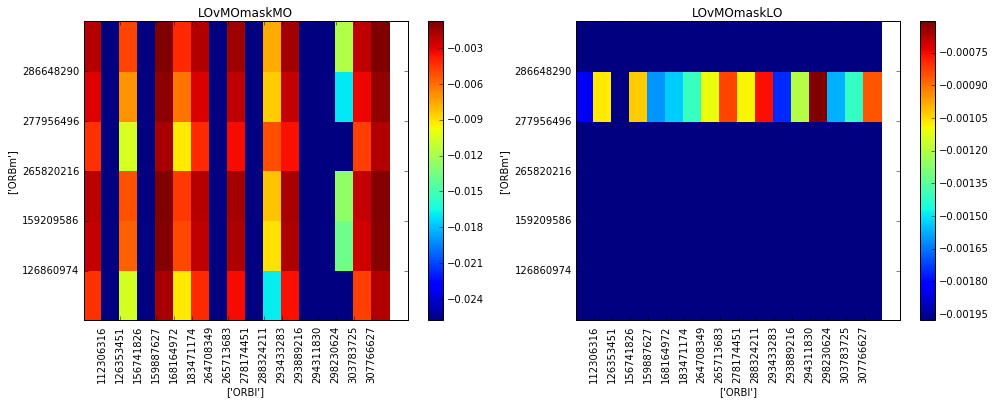

After a second pass of filtering by correlation, experiments had the following correlations between injection sites between regions:
2
True
LOvMOmaskMO: 6 experiments y, 17 expts x, -0.01 overlap
LOvMOmaskLO: 6 experiments y, 17 expts x, -0.00 overlap


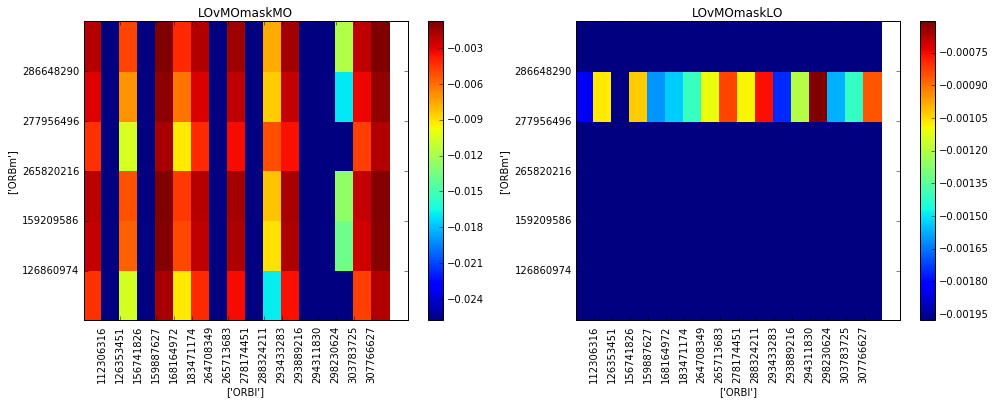

64 large, dense, cortical, non-injection unionizes, 31 structures in LO
The top 3 are: 
+-----+----------+-------+-----+-------------+
|     |   vol    | count |  id | struct_name |
+-----+----------+-------+-----+-------------+
| 723 | 12.38454 |   5   | 723 |     ORBl    |
| 714 |  7.6577  |   2   | 714 |     ORB     |
| 444 | 5.83825  |   2   | 444 |     MED     |
+-----+----------+-------+-----+-------------+
The structures receiving the most projections on average were:
+-----+-----------------+---------------+-----+
|     |   struct_name   |      vol      |  id |
+-----+-----------------+---------------+-----+
| 343 |    Brain stem   | 3.16910551765 | 343 |
| 623 | Cerebral nuclei | 2.81926361765 | 623 |
| 477 |     Striatum    | 2.51757311176 | 477 |
+-----+-----------------+---------------+-----+
31 large, dense, cortical, non-injection unionizes, 25 structures in MO
The top 3 are: 
+-----+---------+-------+-----+-------------+
|     |   vol   | count |  id | struct_name |
+---

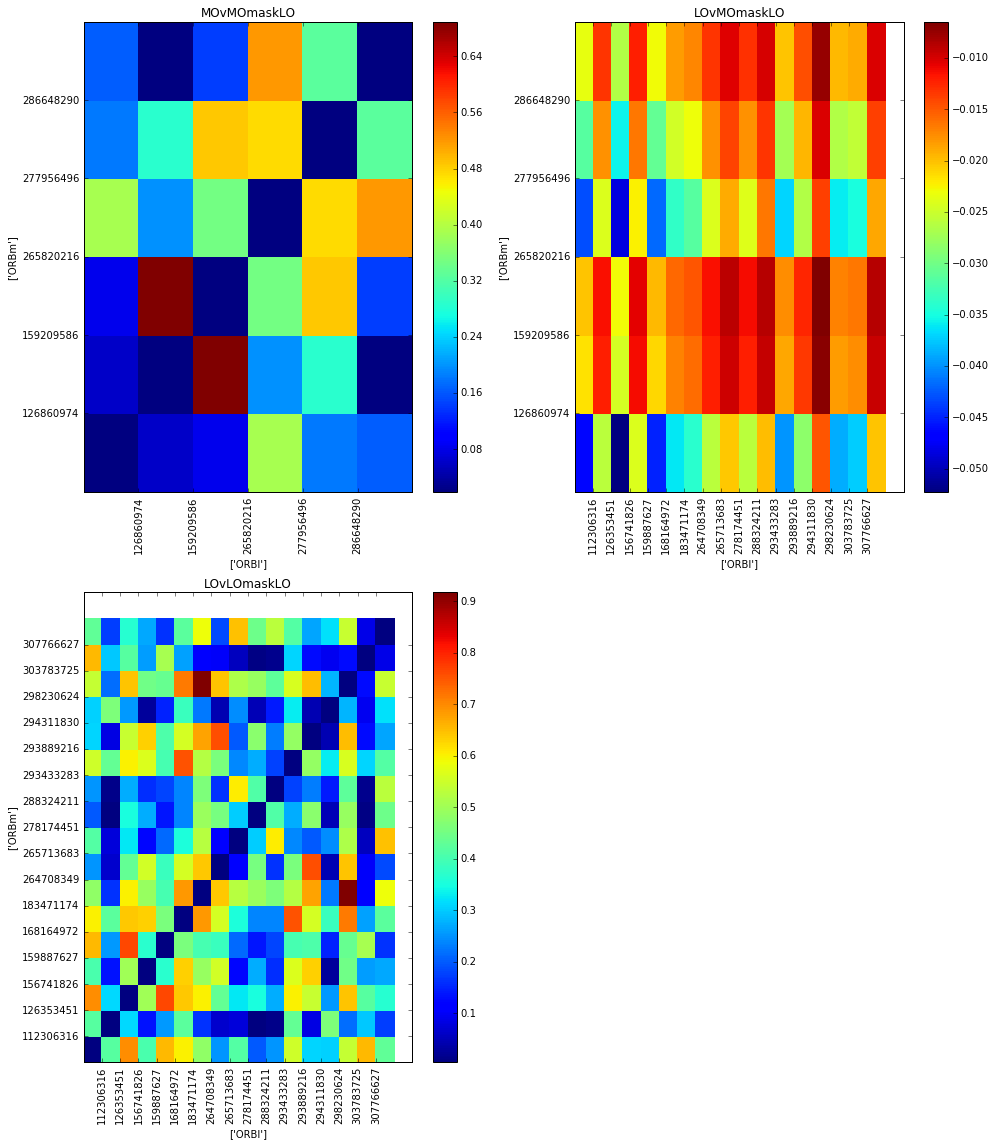

Correlations between projection targets  averaged over the top 3 target regions selected by df_greatest_projection_volumes
3
False
MOvMOmaskLO: 6 experiments y, 6 expts x, nan overlap
LOvMOmaskLO: 6 experiments y, 17 expts x, nan overlap
LOvLOmaskLO: 17 experiments y, 17 expts x, nan overlap


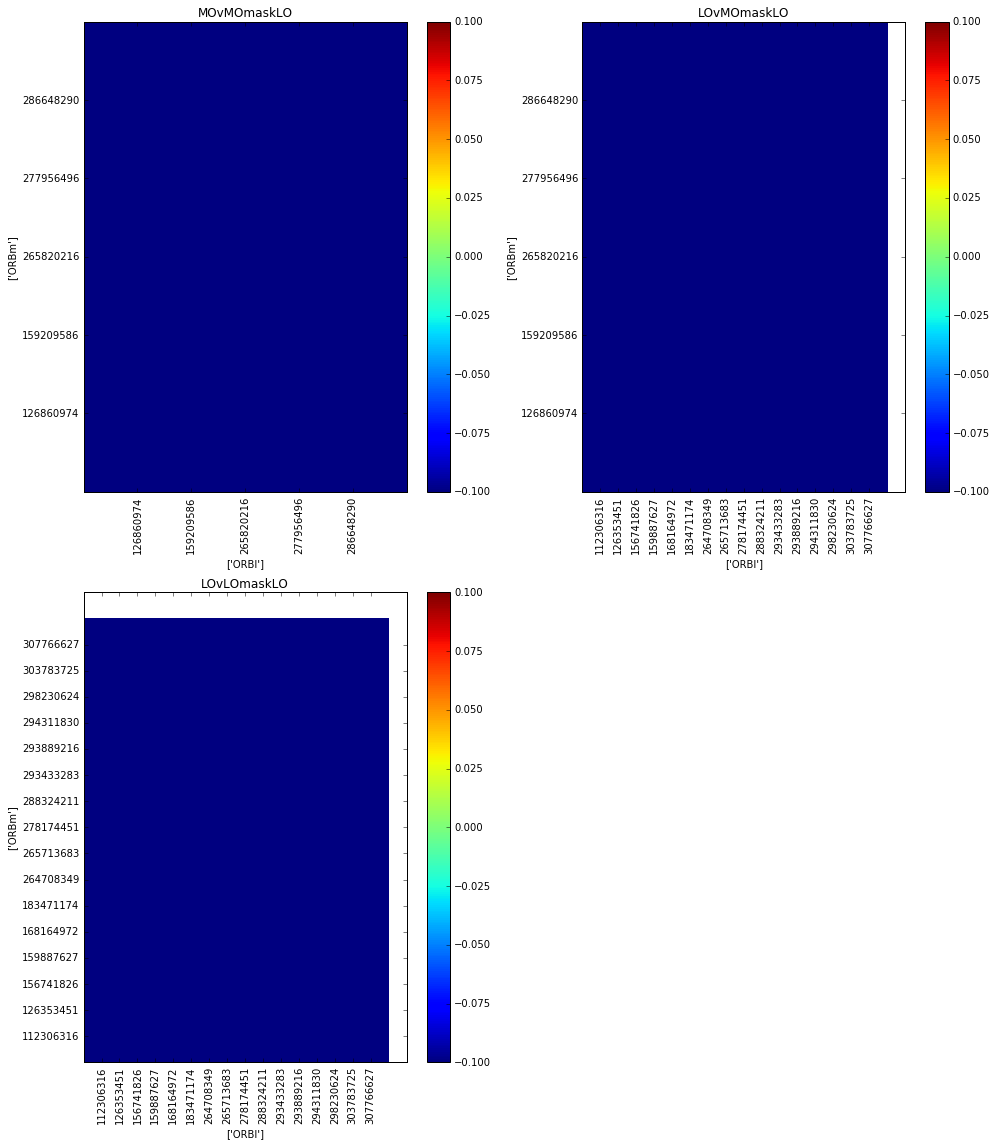

In [ ]:
regions = run_all(settings)

In [ ]:
#if I want to restore variables
#vary = read_pickle(reader,names,1) #,regions2,proj_mask2

In [ ]:
# #fix:
# Correlations between projection targets  for avg of the top 3 target regions selected by 
#df_greatest_projection_volumes # shows up as NaN


In [ ]:
#to do:

In [ ]:
#look at correlations in the main target structures 

In [ ]:
#look at projection target layers within OFC

In [ ]:
#comparisons between wt/same cre-lines 

In [ ]:
#make good visualization for projection targets 

## things i took out of functions to debug